# MNIST Example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.chdir("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# fix seed
torch.manual_seed(1234)
np.random.seed(1234)

cuda


## Load the (vanilla) dataset

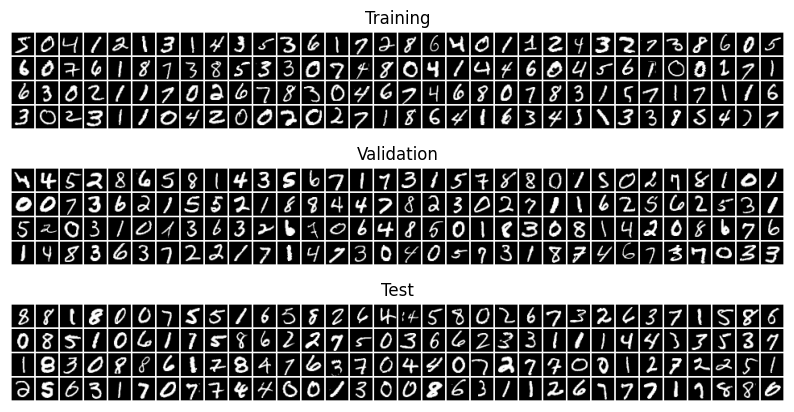

In [2]:
dataset = 'mnist' # or 'fmnist'
batch_size = 128

if dataset == 'mnist':
    # essentially excluding either 6 or 9 as these would cause degenerations under 180 degree rotation
    from src.data import load_mnist
    n_classes = 9
    test_val_split = [5000, 3991]
    train_set = load_mnist(test_set=False, normalize=False)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=4)
    test_set = load_mnist(test_set=True, normalize=False)

elif dataset == 'fmnist':
    n_classes = 10
    test_val_split = [5000, 5000]
    train_set = torchvision.datasets.FashionMNIST('./data/', train=True, download=True, transform=torchvision.transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=4)
    test_set = torchvision.datasets.FashionMNIST('./data/', train=False, download=True, transform=torchvision.transforms.ToTensor())
else:
    raise ValueError('Choose either `mnist` or `fmnist`.')

test_set, val_set = torch.utils.data.random_split(test_set, test_val_split)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))

axs[0].imshow(torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[1].imshow(torchvision.utils.make_grid(next(iter(val_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[2].imshow(torchvision.utils.make_grid(next(iter(test_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

for ax in axs.flat:
    ax.axis('off')

# Transform the test set

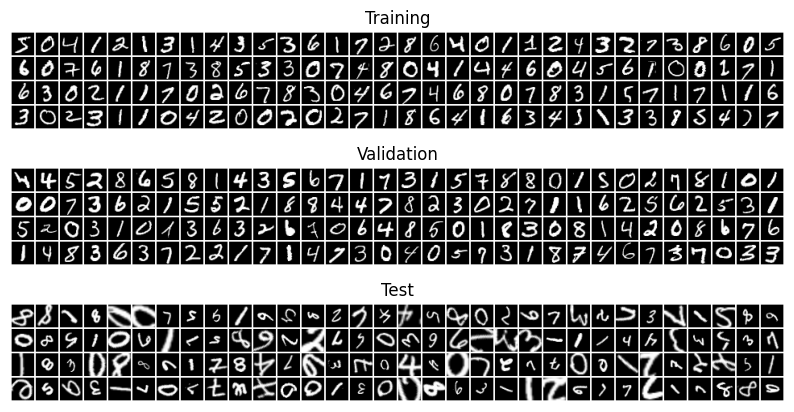

In [3]:
from src.transform import AffineTransformation, multi_transform
from src.data import TransformDataLoader

transformations = [AffineTransformation.ROTATION.value, AffineTransformation.SCALING.value]
domains = [(torch.pi,), (0.5,)]

# odd number guarantees that zero as center of param orbit is included
# increase the number of samples with the increased domain size
n_samples = 9

def transform(data):
    x, y = data
    n = torch.randint(0, n_samples, (x.shape[0], len(transformations)), device=x.device)
    x, _, _ = multi_transform(x, transformations, n, n_samples=n_samples, domain=domains)
    return x, y

test_loader = TransformDataLoader(test_loader, transform)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))

axs[0].imshow(torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[1].imshow(torchvision.utils.make_grid(next(iter(val_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')
axs[2].imshow(torchvision.utils.make_grid(next(iter(test_loader))[0], nrow=batch_size//4, pad_value=1).permute(1, 2, 0), cmap='gray')

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

for ax in axs.flat:
    ax.axis('off')

## Instantiate the model

In [4]:
class ConvNet(nn.Module):
    def __init__(self, n_classes=9):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5)
        self.fc1 = nn.Linear(3*3*16, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.gelu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.gelu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        return F.log_softmax(self.fc2(x), dim=-1)

model = ConvNet(n_classes=n_classes).to(device)
print(model(torch.zeros(batch_size, 1, 28, 28).to(device)).shape)

torch.Size([128, 9])


## Train the model (or load it)

In [5]:
optimiser = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=2e-2)

pbar = tqdm(range(3))
for e in pbar:
    
    model.train()
    train_acc = 0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimiser.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimiser.step()
        train_acc += output.argmax(dim=-1).eq(target).sum().item()
    train_acc /= len(train_set)
    
    model.eval()
    val_acc = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        val_acc += output.argmax(dim=-1).eq(target).sum().item()
    val_acc /= len(val_set)
    
    pbar.set_description(f'Epoch {e} | Train acc@1: {train_acc:.4f} | Validation acc@1: {val_acc:.4f}')
    
torch.save(model, f'./model/{dataset}.pth')

Epoch 2 | Train acc@1: 0.9690 | Validation acc@1: 0.9907: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.67s/it]


## Evaluation on (transformed) test set

In [6]:
model.eval()
test_acc = 0
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    test_acc += output.argmax(dim=-1).eq(target).sum().item()
test_acc /= len(test_set)
print(test_acc)

0.3912


## Same test with ITS

In [7]:
from src.search import InverseTransformationSearch

its = InverseTransformationSearch(model, transformation=transformations, domain=domains,
                                  n_samples=17, n_hypotheses=3, mc_steps=10,
                                  change_of_mind='score', en_unique_class_condition=True)

model.eval()
test_acc = 0
for d, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    data_canonic, embedding = its.infer(data, plot_idx=0 if d==0 else None)
    # pick the class of the leading hypothesis
    output = embedding.argmax(dim=-1)[:, 0]
    test_acc += output.eq(target).sum().item()
test_acc /= len(test_set)
print(test_acc)

/project/johannsc/symmetries/ITS/src/search.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -curvature(torch.tensor(energies, device=z.device))


0.6178


(tensor([[[[[0.0000, 0.0000, 0.0000,  ..., 0.0216, 0.0276, 0.0507],
            [0.0000, 0.0000, 0.0000,  ..., 0.0638, 0.1312, 0.1358],
            [0.0069, 0.0000, 0.0000,  ..., 0.2674, 0.2976, 0.3814],
            ...,
            [0.0000, 0.0000, 0.0705,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
          [[[0.0047, 0.0274, 0.1833,  ..., 0.0000, 0.0000, 0.0000],
            [0.0034, 0.0618, 0.1800,  ..., 0.1986, 0.1092, 0.0199],
            [0.0011, 0.0919, 0.2199,  ..., 0.4414, 0.3249, 0.2356],
            ...,
            [0.8971, 0.9682, 0.9725,  ..., 0.0000, 0.0000, 0.0000],
            [0.9763, 0.9858, 0.9881,  ..., 0.0000, 0.0000, 0.0000],
            [0.9900, 0.9899, 0.9884,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
  

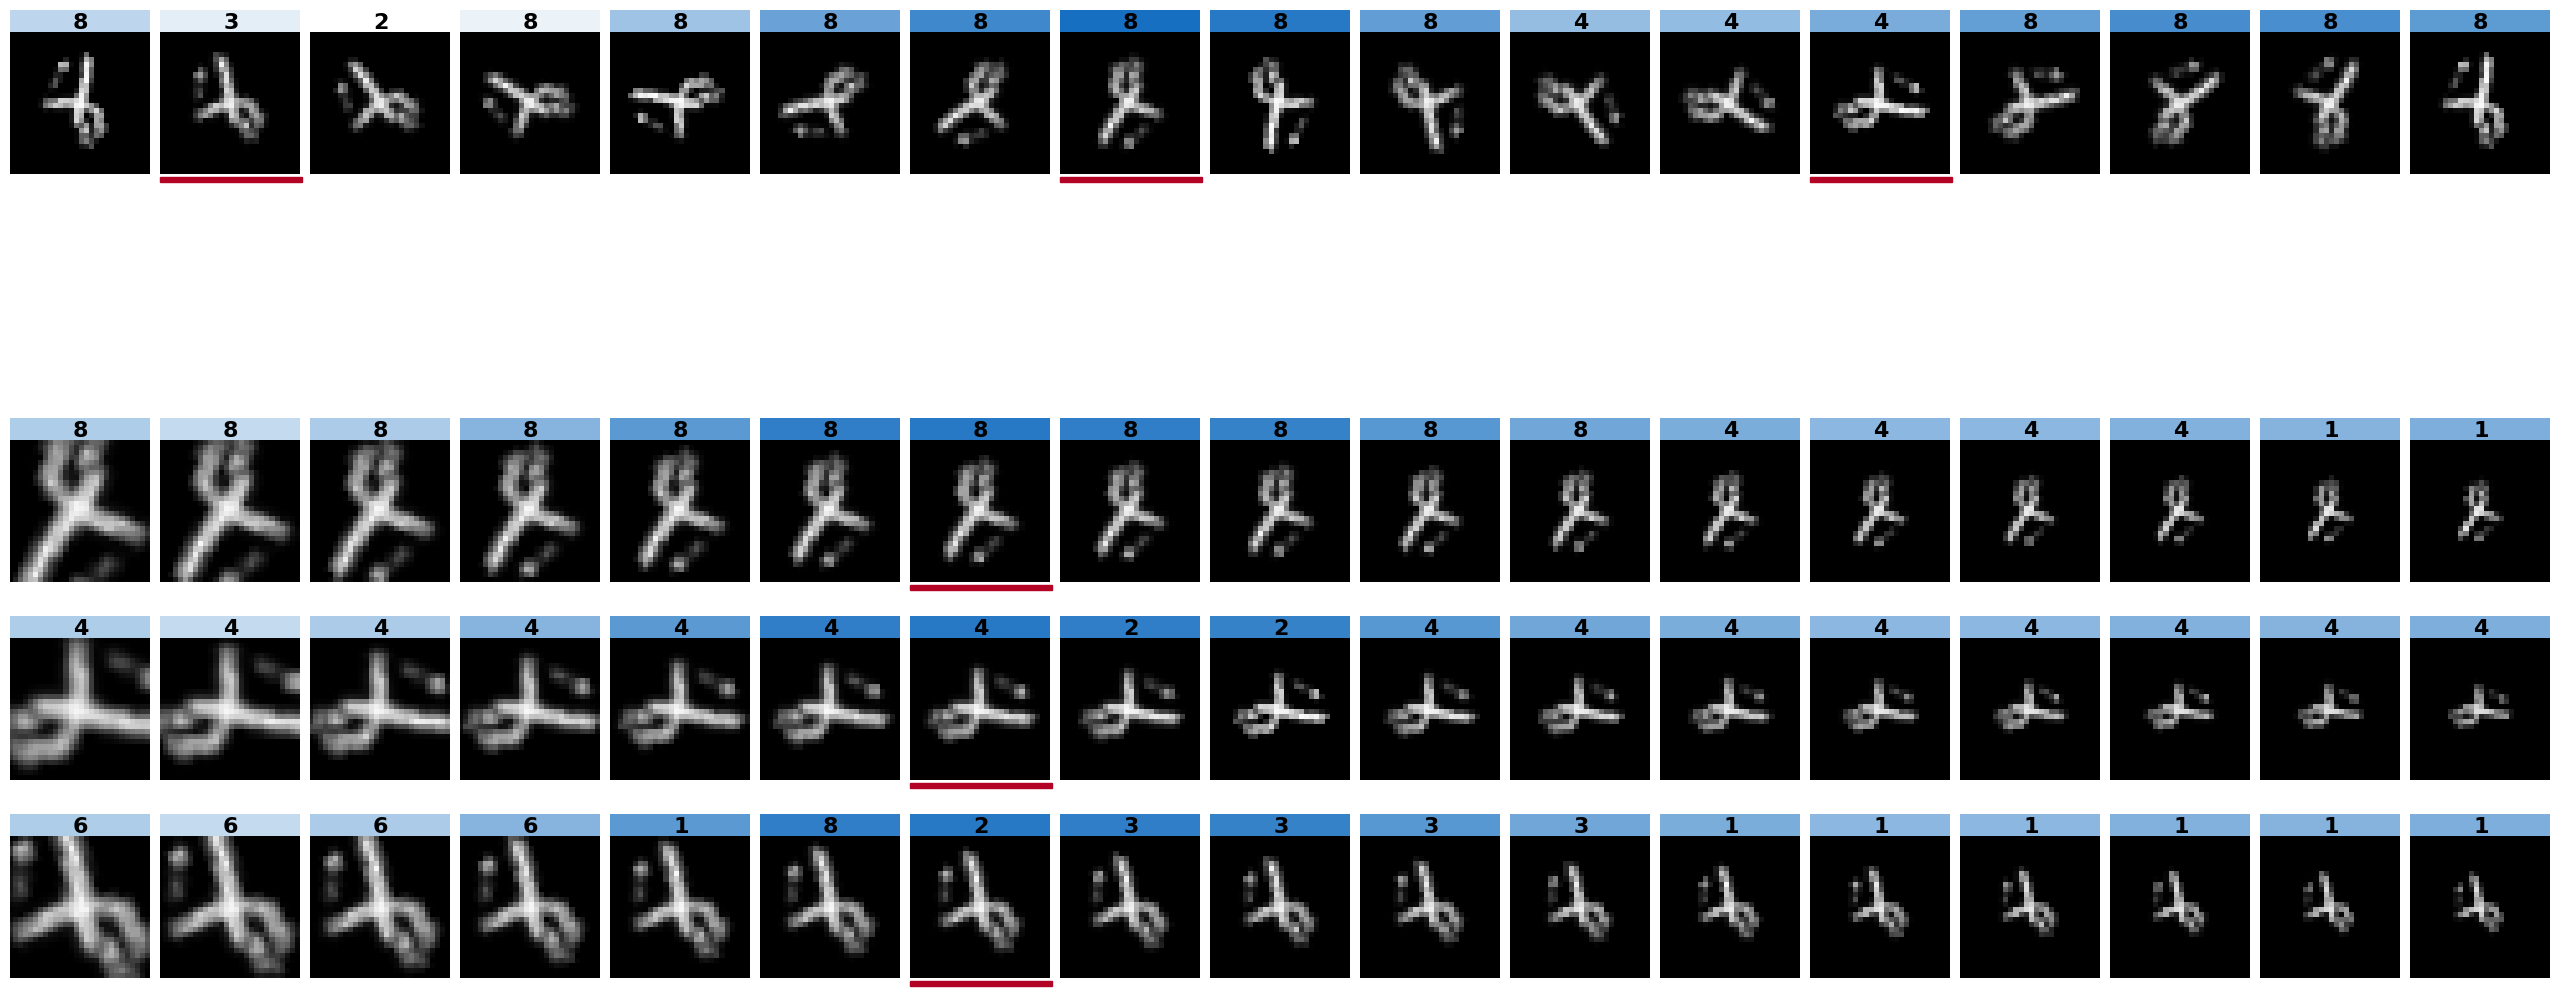

In [11]:
its.infer(data, plot_idx=1)